In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
path='/content/drive/Shareddrives/Deep Learning/Data/cleaned_data.csv'
df=pd.read_csv(path)

In [3]:
df.head()

,qid1,qid2,question1_cleaned,question2_cleaned,is_duplicate
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


#Word2Vec Implementation

In [4]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense
from sklearn.model_selection import train_test_split


# Load pre-trained Word2Vec model
word2vec_model_path = '/content/drive/Shareddrives/Deep Learning/Embedding File/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True, limit=500000)

# Convert all values in 'question1_cleaned' and 'question2_cleaned' columns to strings
df['question1_cleaned'] = df['question1_cleaned'].astype(str)
df['question2_cleaned'] = df['question2_cleaned'].astype(str)

# fit a tokenizer with questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["question1_cleaned"].values+df["question2_cleaned"].values)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 175861


In [5]:
# create sequences
max_len = 50
q1_texts_seq = tokenizer.texts_to_sequences(df["question1_cleaned"].values)
q2_texts_seq = tokenizer.texts_to_sequences(df["question2_cleaned"].values)

q1_texts_seq = pad_sequences(q1_texts_seq,maxlen=max_len)
q2_texts_seq = pad_sequences(q2_texts_seq,maxlen=max_len)

In [6]:
embedding_dim = 300

# Convert tokenized sequences to Word2Vec embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

In [7]:
X = np.stack((q1_texts_seq, q2_texts_seq), axis=1)
y = df["is_duplicate"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get Question 1/2  train and test features
q1_X_train = X_train[:,0]
q2_X_train = X_train[:,1]

q1_X_test = X_test[:,0]
q2_X_test = X_test[:,1]

#Building the LSTM Model

In [8]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

# Define input shapes and LSTM hidden units
input_shape = (max_len,)
lstm_hidden_units = 128

# Input layers
input_q1 = Input(shape=input_shape, name='input_q1')
input_q2 = Input(shape=input_shape, name='input_q2')

# Embedding layers
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=input_shape[0], trainable=False)
embedded_q1 = embedding_layer(input_q1)
embedded_q2 = embedding_layer(input_q2)

# LSTM layers
lstm_layer = LSTM(lstm_hidden_units, dropout=0.2, recurrent_dropout=0.2)

# LSTM for both inputs
lstm_output_q1 = lstm_layer(embedded_q1)
lstm_output_q2 = lstm_layer(embedded_q2)

# Concatenate LSTM outputs
concatenated = Concatenate(axis=-1)([lstm_output_q1, lstm_output_q2])

# Dense layer for classification
dense_layer = Dense(128, activation='relu')(concatenated)
dropout_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Define the model
lstm_model = Model(inputs=[input_q1, input_q2], outputs=output_layer)

# Model Compilation and Training

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_q1 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_q2 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 300)              5275830   ['input_q1[0][0]',            
                                                          0          'input_q2[0][0]']            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  219648    ['embedding[0][0]',       

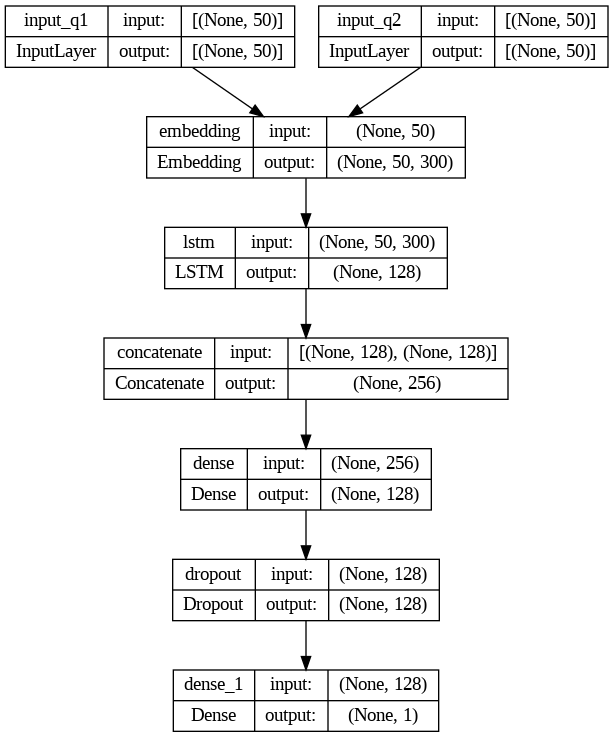

In [9]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
lstm_model.summary()

from tensorflow.keras.utils import plot_model
plot_model(lstm_model, to_file='model.png', show_shapes=True)

In [ ]:
# Train the model
history=lstm_model.fit([q1_X_train, q2_X_train], y_train, batch_size=64, epochs=20, validation_split=0.1)


Epoch 1/20
4549/4549 [==============================] - 880s 192ms/step - loss: 0.5132 - accuracy: 0.7385 - val_loss: 0.4611 - val_accuracy: 0.7742
Epoch 2/20
4549/4549 [==============================] - 867s 191ms/step - loss: 0.4492 - accuracy: 0.7808 - val_loss: 0.4277 - val_accuracy: 0.7954
Epoch 3/20
4549/4549 [==============================] - 872s 192ms/step - loss: 0.4156 - accuracy: 0.8003 - val_loss: 0.4079 - val_accuracy: 0.8059
Epoch 4/20
4549/4549 [==============================] - 884s 194ms/step - loss: 0.3926 - accuracy: 0.8140 - val_loss: 0.3941 - val_accuracy: 0.8155
Epoch 5/20
4549/4549 [==============================] - 880s 193ms/step - loss: 0.3729 - accuracy: 0.8253 - val_loss: 0.3885 - val_accuracy: 0.8193
Epoch 6/20
4549/4549 [==============================] - 876s 193ms/step - loss: 0.3554 - accuracy: 0.8353 - val_loss: 0.3870 - val_accuracy: 0.8189
Epoch 7/20
4549/4549 [==============================] - 870s 191ms/step - loss: 0.3419 - accuracy: 0.8420 - val_

# Visualization for Learning Curve

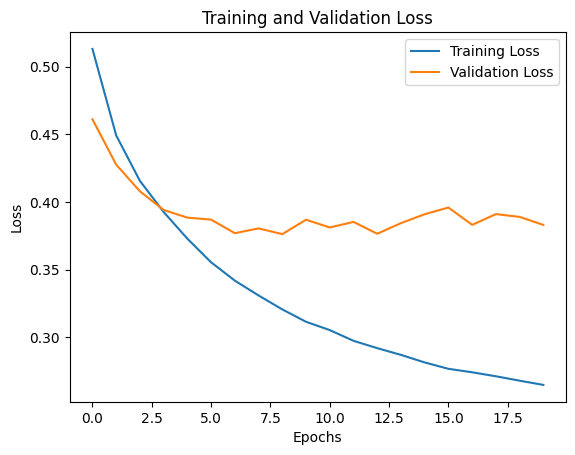

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


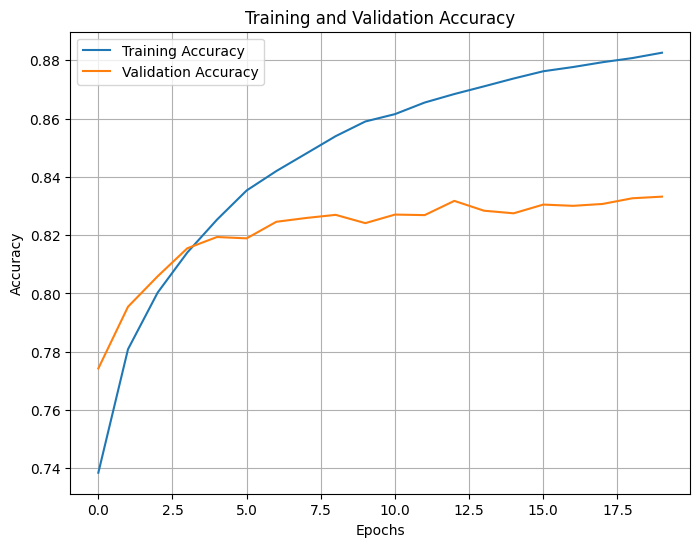

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Model Saving

In [ ]:
import pickle

# Choose a File Path
model_file_path = '/content/drive/Shareddrives/Deep Learning/Saved_Model/SiamLSTMmodel.h5'
tokenizer_file_path = '/content/drive/Shareddrives/Deep Learning/Saved_Model/SiamLSTMtokenizer.pkl'

# Save the Model
lstm_model.save(model_file_path)

#  Save the Tokenizer
with open(tokenizer_file_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Loading

In [10]:
import pickle
from tensorflow.keras.models import load_model

# File paths for the saved model and tokenizer
model_file_path = '/content/drive/Shareddrives/Deep Learning/Saved_Model/SiamLSTMmodel.h5'
tokenizer_file_path = '/content/drive/Shareddrives/Deep Learning/Saved_Model/SiamLSTMtokenizer.pkl'

#  Load the Model
lstm_loaded_model = load_model(model_file_path)

#  Load the Tokenizer
with open(tokenizer_file_path, 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)


# Model Evaluation

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report

# Evaluate the model on test data
test_loss, test_accuracy = lstm_loaded_model.evaluate([q1_X_test, q2_X_test], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict the labels for test data
y_pred = lstm_loaded_model.predict([q1_X_test, q2_X_test])
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


2527/2527 [==============================] - 102s 40ms/step - loss: 0.3855 - accuracy: 0.8331
Test Loss: 0.38546642661094666
Test Accuracy: 0.8330901265144348
2527/2527 [==============================] - 101s 40ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     50803
           1       0.75      0.83      0.79     30055

    accuracy                           0.83     80858
   macro avg       0.82      0.83      0.82     80858
weighted avg       0.84      0.83      0.83     80858



# Model Prediction

In [12]:
def preprocess_text(text):
    # Tokenize the text
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

def predict_similarity(text1, text2):
    # Preprocess the input texts
    processed_text1 = preprocess_text(text1)
    processed_text2 = preprocess_text(text2)
    # Predict similarity using the trained model
    similarity = lstm_loaded_model.predict([processed_text1, processed_text2])[0][0]
    return similarity

def classify_paraphrase(text1, text2, threshold=0.5):
    similarity_score = predict_similarity(text1, text2)
    if similarity_score >= threshold:
        classification = "These questions are paraphrased."
    else:
        classification = "These questions are not paraphrased."
    return classification, similarity_score

# Interactive loop to take input from the user
while True:
    text1 = input("Enter the first question (or type 'quit' to exit): ")
    if text1.lower() == 'quit':
        print("Exiting...")
        break
    text2 = input("Enter the second question: ")
    if text1.lower() == text2.lower():
        print("These questions are exactly the same (Case insensitive)")
        print("Similarity Score: 1.0000000")
        continue

    # Classify as paraphrase or not
    result, similarity_score = classify_paraphrase(text1, text2)
    print(result)
    print("Similarity Score:", similarity_score)

Enter the first question (or type 'quit' to exit): what are the benefits of using renewable energy?
Enter the second question: what are the advantages of using renewable energy?
1/1 [==============================] - 0s 81ms/step
These questions are paraphrased.
Similarity Score: 0.9446887
Enter the first question (or type 'quit' to exit): what are the effects of climate change on marine ecosystem?
Enter the second question: how does climate change  impact marine environment?
1/1 [==============================] - 0s 53ms/step
These questions are paraphrased.
Similarity Score: 0.8910987
Enter the first question (or type 'quit' to exit): what is organic farming?
Enter the second question: how does the use pesticides affects farming?
1/1 [==============================] - 0s 73ms/step
These questions are not paraphrased.
Similarity Score: 0.039908547
Enter the first question (or type 'quit' to exit): quit
Exiting...
